### Imports

In [31]:
#%pip install scikeras

In [32]:
import json
import tensorflow as tf
import keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

### Constants

In [33]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

LABELS = [
    "T-Shirt/Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Boot"
]

N_CLASSES = len(LABELS)

WEIGHTS_FILENAME = "models/best_multiclass_model.weights.h5"
HYPERPARAMS_FILENAME = "models/best_multiclass_model.hyperparams.json"

In [34]:
IS_TO_FIND_BEST_HYPERPARAMS = True
IS_TO_TRAIN = True
IS_TO_REPLICATE = True

In [35]:
SEED = None if IS_TO_TRAIN else 12345
MAX_EPOCHS = 50

### Callback functions

In [36]:
# Callbacks
BEST_MODEL_CHECKPOINT = kr.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_FILENAME,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True
)

EARLY_STOPPING = kr.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

## Data Loading and Preprocessing

Next, the Fashion MNIST dataset will be loaded and prepared for training:
1. Load the dataset using Keras
2. Normalize the pixel values to the range [0,1]
3. Split the training data to create a validation set (80% training, 20% validation)

In [37]:
# Load dataset FASHION_MNIST
dataset = kr.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = dataset.load_data()

# Split threshold definition
SPLIT = x_train_full.shape[0] * 8 // 10

# Normalize data and spit into training and validation
x_train = x_train_full[:SPLIT, :] / 255.
x_val = x_train_full[SPLIT:, :] / 255.
x_test = x_test / 255.

# Transform training subset labels into one-hot encoding
y_train_full_mx = kr.utils.to_categorical(y_train_full, N_CLASSES)

# Split labels into training and validation
y_train = y_train_full_mx[:SPLIT, :]
y_val = y_train_full_mx[SPLIT:, :]

# Transform test subset labels into one-hot encoding
y_test_mx = kr.utils.to_categorical(y_test, N_CLASSES)

The Fashion MNIST dataset consists of grayscale images, represented as 2D arrays. As these images do not contain color information, each pixel value corresponds to the luminance (brightness) of the image. The following histograms provide evidence supporting this observation by illustrating the distribution of pixel values for the hue and saturation components.

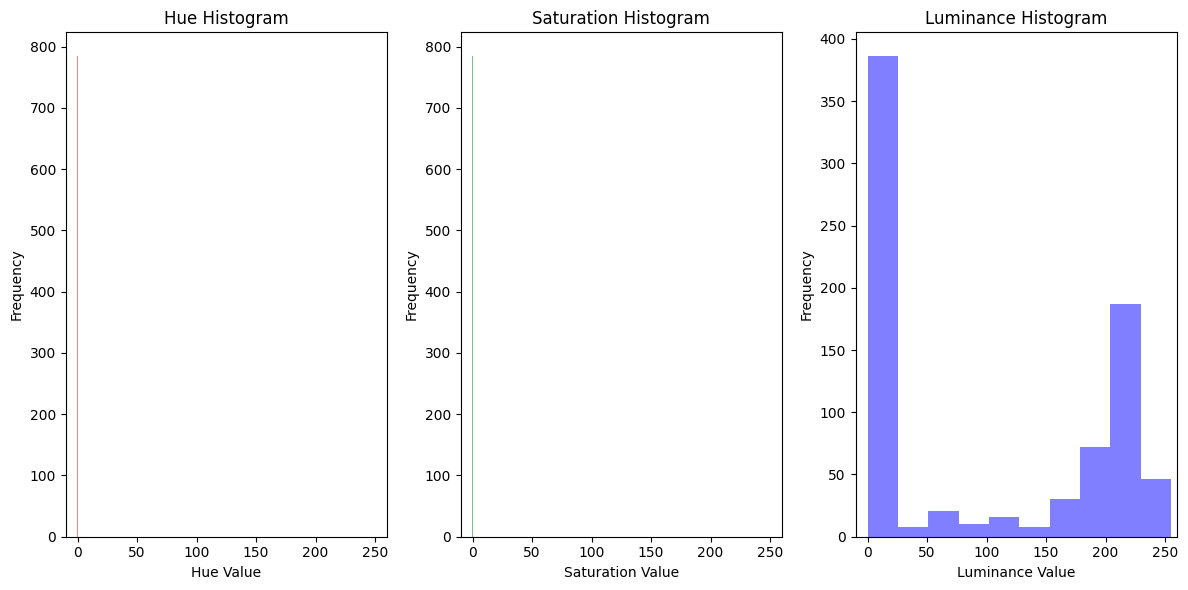

In [38]:
image = x_train_full[0]
image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

# Plot histogram for hue values
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(image_hsv[:, :, 0].ravel(), bins=1, color='red', alpha=0.5)
plt.title('Hue Histogram')
plt.xlim([-10, 260])
plt.xlabel('Hue Value')
plt.ylabel('Frequency')

# Plot histogram for saturation values
plt.subplot(1, 3, 2)
plt.hist(image_hsv[:, :, 1].ravel(), bins=1, color='green', alpha=0.5)
plt.title('Saturation Histogram')
plt.xlim([-10, 260])
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')

# Plot histogram for luminance values
plt.subplot(1, 3, 3)
plt.hist(image_hsv[:, :, 2].ravel(), bins=10, color='blue', alpha=0.5)
plt.title('Luminance Histogram')
plt.xlim([-10, 260])
plt.xlabel('Luminance Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Since the hue and saturation components of the image are zero, it is evident that the grayscale representation directly corresponds to the luminance component of each image. This implies that the brightness information is solely captured by the grayscale values, making it a reliable representation of the image's luminance.

### Dataset summary

In [39]:
# Output dataset information
print("Number of samples in the original training set: " + str(x_train_full.shape[0]))
print("Number of samples in the original test set: " + str(x_test.shape[0]))

print(f"\nDimensions of the training dataset: {x_train.shape[0]}. Does it correspond to 80%? {'Yes' if x_train.shape[0] == int(0.8 * x_train_full.shape[0]) else 'No'}")
print(f"Dimensions of the validation dataset: {x_val.shape[0]}. Does it correspond to 20%? {'Yes' if x_val.shape[0] == int(0.2 * x_train_full.shape[0]) else 'No'}")

# Validate if dataset is shuffled
is_shuffled = not np.array_equal(y_train_full, np.sort(y_train_full))
print(f"\nIs the dataset shuffled? {'Yes' if is_shuffled else 'No'}")

Number of samples in the original training set: 60000
Number of samples in the original test set: 10000

Dimensions of the training dataset: 48000. Does it correspond to 80%? Yes
Dimensions of the validation dataset: 12000. Does it correspond to 20%? Yes

Is the dataset shuffled? Yes


### Classes examples visualization

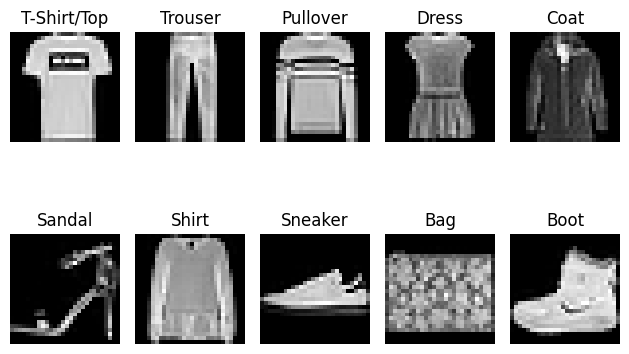

In [40]:
# Visualize an example from each class
for i, label in enumerate(LABELS):
    plt.subplot(2, 5, i + 1)
    plt.title(label)
    class_indices = np.where(y_train_full == i)[0]
    example_index = class_indices[0]
    plt.imshow(x_train_full[example_index], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## 4. Model Architecture

Simple neural network for multiclass classification:
1. Input layer for 28×28 grayscale images
2. Flatten layer to convert 2D images to 1D
3. Dense hidden layer with ReLU activation
4. Output layer with softmax activation for multiclass classification

### Guide to determine ANN number of neurons
+ The number of hidden neurons should be between the size of the input layer and the size of the output layer.
+ The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
+ The number of hidden neurons should be less than twice the size of the input layer.

source: [Introduction to Neural Networks for Java, Second Edition by Jeff Heaton](https://books.google.pt/books/about/Introduction_to_Neural_Networks_with_Jav.html?id=Swlcw7M4uD8C&redir_esc=y)

In [41]:
# Network weight initialization
initializer = kr.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)

# Model definition
fashion_model = kr.Sequential([
    kr.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT)),
    kr.layers.Flatten(),
    kr.layers.Dense((IMG_WIDTH * IMG_HEIGHT + N_CLASSES) * 2 // 3, activation='relu', kernel_initializer=initializer),
    kr.layers.Dense(N_CLASSES, activation='softmax', kernel_initializer=initializer)
], name="Fashion_MNIST_Multiclass_Model")

fashion_model.summary()

Model: "Fashion_MNIST_Multiclass_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 529)            │       415,265 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,565 (1.60 MB)

 Trainable params: 420,565 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Exploring the data to:
1. Find the best hyper parameters that maximize the model accuracy
2. From the best hyper parameters, store the best weights that maximize the accuracy and minimizes the loss
3. Save the best ANN model weights combination

In [42]:
if IS_TO_FIND_BEST_HYPERPARAMS:
    SEED = 12345

    # Function to create model, required for KerasClassifier
    def create_model(learning_rate):
        global fashion_model

        fashion_model.compile(
            loss='categorical_crossentropy',
            optimizer=kr.optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy']
        )

        return fashion_model

    # Create the KerasClassifier
    model = KerasClassifier(model=create_model, verbose=0)

    # Define the grid search parameters
    param_grid = {
        'batch_size': [64, 128, 256, 512, 1024, 2048],
        'epochs': [MAX_EPOCHS],
        'model__learning_rate': np.linspace(0.0001, 0.1, 10)
    }

    # Create GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=0)

    grid_result = grid.fit(x_train, y_train)

    best_params = grid_result.best_params_

    # Save the best parameters to a JSON file
    with open(HYPERPARAMS_FILENAME, 'w') as json_file:
        json.dump(grid_result.best_params_, json_file, indent=4)

    print(f"\n\n\nBest model hyper parameters: {json.dumps(grid_result.best_params_, indent=4)}")

else:
    with open(HYPERPARAMS_FILENAME, 'r') as json_file:
        best_params = json.load(json_file)
        print(f"Best model hyper parameters from file: {json.dumps(best_params, indent=4)}")

2025-03-04 17:00:07.905871: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-04 17:00:07.905924: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-04 17:00:07.905931: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1741107607.905951 1057277 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741107607.905983 1057277 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-04 17:00:07.962889: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-04 17:00:07.962919: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-04 17:00:07.962922: I metal_plugin/src/device/




Best model hyper parameters: {
    "batch_size": 256,
    "epochs": 50,
    "model__learning_rate": 0.0001
}


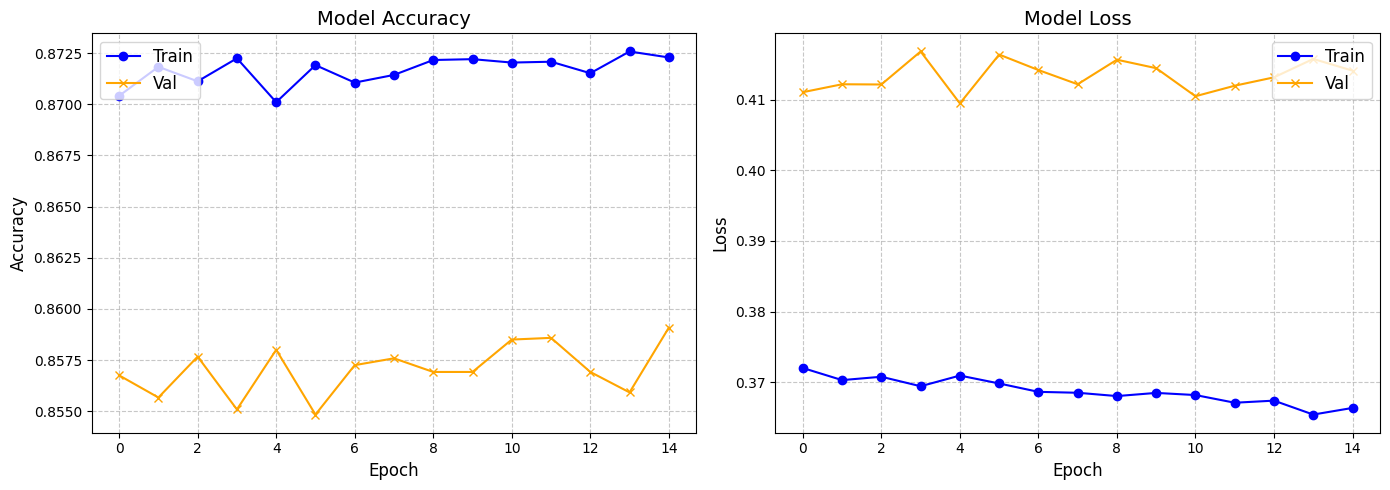

In [43]:
if IS_TO_TRAIN:
    SEED = None
    fashion_model.compile(
        loss="categorical_crossentropy",
        optimizer=kr.optimizers.Adam(learning_rate=best_params["model__learning_rate"]),
        metrics=["accuracy"]
    )

    learning_hist = fashion_model.fit(
        x_train,
        y_train,
        batch_size=best_params["batch_size"],
        epochs=MAX_EPOCHS,
        validation_data=(x_val, y_val),
        callbacks=[BEST_MODEL_CHECKPOINT, EARLY_STOPPING],
        verbose=0
    )

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    axs[0].plot(learning_hist.history['accuracy'], label='Train', color='blue', linestyle='-', marker='o')
    axs[0].plot(learning_hist.history['val_accuracy'], label='Val', color='orange', linestyle='-', marker='x')
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_xlabel('Epoch', fontsize=12)
    axs[0].legend(loc='upper left', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    # Plot loss
    axs[1].plot(learning_hist.history['loss'], label='Train', color='blue', linestyle='-', marker='o')
    axs[1].plot(learning_hist.history['val_loss'], label='Val', color='orange', linestyle='-', marker='x')
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_xlabel('Epoch', fontsize=12)
    axs[1].legend(loc='upper right', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [44]:
if IS_TO_REPLICATE:
    fashion_model.load_weights(WEIGHTS_FILENAME)

# Predict the test set
y_pred = fashion_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

# Evaluate the model
test_loss, test_acc = fashion_model.evaluate(x_test, y_test_mx, verbose=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate model's recall and precision metrics
recall = np.diag(cm) / np.sum(cm, axis=1)
precision = np.diag(cm) / np.sum(cm, axis=0)

## Model Evaluation

In [45]:
results_table = pd.DataFrame({
    'Metric': ['Test Loss', 'Test Accuracy'],
    'Value': np.round([test_loss, test_acc], 4)
})

results_table

,Metric,Value
0,Test Loss,0.4376
1,Test Accuracy,0.8467


### Model recall and precision by label

In [46]:
# Create a table to show each label's recall and precision
recall_precision_table = pd.DataFrame({
    'Label': LABELS,
    'Recall (%)': np.round(recall * 100, 1),
    'Precision (%)': np.round(precision * 100, 1)
})

recall_precision_table

,Label,Recall (%),Precision (%)
0,T-Shirt/Top,80.9,80.9
1,Trouser,95.8,97.6
2,Pullover,76.6,70.1
3,Dress,86.2,83.9
4,Coat,77.0,72.7
5,Sandal,92.9,94.6
6,Shirt,54.0,64.3
7,Sneaker,93.6,92.1
8,Bag,94.3,95.1
9,Boot,95.4,94.5


### Model confusion matrix

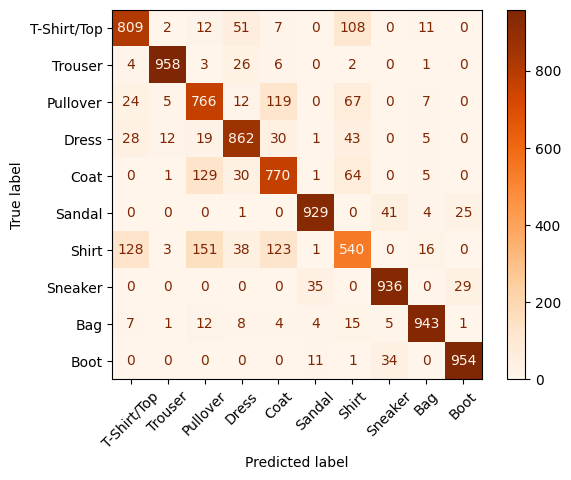

In [47]:
# Plot the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=LABELS).plot(cmap=plt.colormaps['Oranges'], xticks_rotation=45)
plt.show()

## Confusion Matrix analysis

Analyzing the confusion matrix, one can observe that the model learned with precision what is a bag, boot, sneaker, and sandal. The model effectively identified the differences between these types of footwear and bags. Regarding the clothing major group, the model performed very well in recognizing trousers. However, for shirts, coats, and pullovers, the model's performance was not as strong. This might be related to the lack of visual differences and the lack of detail in the images to understand the texture of the fabric. Incorporating texture features might help the model better distinguish between different types of clothing.

For the shirt category, the model often predicted other labels such as t-shirt, pullover, and coat, with these categories having more misclassified images. The reverse also occurred, with some t-shirts, pullovers, dresses, and coats being misclassified as shirts.

This misclassification pattern was not limited to shirts. Pullovers were often misclassified as coats, and vice versa.